In [1]:
import sqlite3
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import MathsUtilities as MUte
%matplotlib inline

In [2]:
Colors = ['black',
 'bisque',
 'forestgreen',
 'slategrey',
 'darkgrey',
 'springgreen',
 'darkblue',
 'lightgrey',
 'orange',
 'aquamarine',
 'blue',
 'rosybrown',
 'goldenrod',
 'lightseagreen',
 'mediumpurple',
 'firebrick',
 'palegoldenrod',
 'teal',
 'thistle',
 'salmon',
 'olive',
 'cyan',
 'violet',
 'orangered',
 'yellowgreen',
 'deepskyblue',
 'orchid',
 'sandybrown',
 'lawngreen',
 'dodgerblue',
 'pink']
Markers = ['o','s','^','x']

### Link to APSIM output Data

In [3]:
con = sqlite3.connect(r'C:\GitHubRepos\ApsimX\Prototypes\Potato\Potato.db')

### Read the Simulations table that has SimulationID matched to Simulation Name

In [4]:
Simulations = pd.read_sql("Select * from _Simulations",
                                con)
Simulations.set_index('ID',inplace=True)

### Read in the Factor table that links factor names and levels to simulation IDs

In [5]:
Factors = pd.read_sql("Select * from _Factors",
                        con)
Factors.set_index('SimulationID',inplace=True)

### Read in the Report generated on the Sowing Event

In [6]:
LocList = pd.read_excel(r'C:\Users\cflhxb\Dropbox\APSIMPotato\List of locations.xlsx')
LocList.set_index('metfile',inplace=True)

In [7]:
import re
def extractLocation(lcn):
    lcn = lcn.replace('MET files\\','')
    lcn = re.sub('\d','',lcn)
    lcn = lcn.replace('.met','')
    return lcn
def extractfileName(fn):
    fn = fn.replace('MET files\\','')
    fn = fn.replace('.met','')
    return fn

In [8]:
Obs = pd.read_sql("Select * from Observed",
                        con)
Obs.set_index('SimulationID',inplace=True)

In [9]:
InitialReport = pd.read_sql("Select * from InitialReport",
                        con)
InitialReport.loc[:,'SimulationName'] = [Simulations.loc[InitialReport.loc[x,'SimulationID'],'Name'] for x in InitialReport.index]
InitialReport.drop(['CheckpointID','Zone','Nitrogen','01','1','Field_','_','Water','Radiation','PlantDensity'],axis=1,inplace=True)
InitialReport.set_index('SimulationID',inplace=True)
InitialReport.loc[:,'Location'] = [extractLocation(x) for x in InitialReport.loc[:,'Weather.FileName']]
InitialReport.loc[:,'FileName'] = [extractfileName(InitialReport.loc[x,'Weather.FileName']) for x in InitialReport.index]
InitialReport.loc[:,'Country'] = [LocList.loc[x,'country'] for x in InitialReport.loc[:,'FileName']]
InitialReport.loc[:,'Loc'] = [LocList.loc[x,'loc'] for x in InitialReport.loc[:,'FileName']]
InitialReport.loc[:,'Country Loc'] = [InitialReport.loc[x,'Country'] + ' ' + InitialReport.loc[x,'Loc'] for x in InitialReport.index] 

In [10]:
DailyReport = pd.read_sql("Select * from DailyReport",
                        con)
DailyReport.loc[:,'SimulationName'] = [Simulations.loc[DailyReport.loc[x,'SimulationID'],'Name'] for x in DailyReport.index]
DailyReport.drop(['CheckpointID','Zone','Nitrogen','01','1','Field_','_','Water','Radiation','PlantDensity'],axis=1,inplace=True)
DailyReport.set_index('SimulationID',inplace=True)

In [11]:
DailyPreObs = pd.read_sql("Select * from TimeSeriesData",
                        con)
DailyPreObs.loc[:,'SimulationName'] = [Simulations.loc[DailyPreObs.loc[x,'SimulationID'],'Name'] for x in DailyPreObs.index]
DailyPreObs.set_index('SimulationID',inplace=True)
DailyPreObs.drop_duplicates(inplace=True)

In [12]:
HarvestReport = pd.read_sql("Select * from HarvestReport",
                        con)
HarvestReport.loc[:,'SimulationName'] = [Simulations.loc[HarvestReport.loc[x,'SimulationID'],'Name'] for x in HarvestReport.index]
HarvestReport.drop(['CheckpointID','Zone','Nitrogen','01','1','Field_','_','Water','Radiation','PlantDensity'],axis=1,inplace=True)
HarvestReport.loc[:,'PlantPopn'] = 1/((HarvestReport.loc[:,'RowWidth']/1000)* (HarvestReport.loc[:,'InterRowPlantSpace']/1000))
HarvestReport.loc[:,'StemPopn'] = HarvestReport.loc[:,'StemPerTuber'] *  HarvestReport.loc[:,'PlantPopn']
HarvestReport.loc[:,'Location'] = [extractLocation(x) for x in HarvestReport.loc[:,'Weather.FileName']]
HarvestReport.set_index('SimulationID',inplace=True)
HarvestReport.loc[:,'FileName'] = [extractfileName(HarvestReport.loc[x,'Weather.FileName']) for x in HarvestReport.index]
HarvestReport.loc[:,'Country'] = [LocList.loc[x,'country'] for x in HarvestReport.loc[:,'FileName']]
HarvestReport.loc[:,'Loc'] = [LocList.loc[x,'loc'] for x in HarvestReport.loc[:,'FileName']]
HarvestReport.loc[:,'Country Loc'] = [HarvestReport.loc[x,'Country'] + ' ' + HarvestReport.loc[x,'Loc'] for x in HarvestReport.index] 

In [13]:
HarvestPreObs = pd.read_sql("Select * from FinalYieldData",
                        con)
HarvestPreObs.loc[:,'SimulationName'] = [Simulations.loc[HarvestPreObs.loc[x,'SimulationID'],'Name'] for x in HarvestPreObs.index]
HarvestPreObs.set_index('SimulationID',inplace=True)
HarvestPreObs.drop_duplicates(inplace=True)

### List of simulation names that are in observations data set but are not triggering a sowing event

In [14]:
NotPlanted = []
for x in DailyPreObs.index.get_level_values(0).drop_duplicates():
    if x not in InitialReport.index:
        NotPlanted.append(Simulations.loc[x,'Name'])
NotPlanted

['SFF_03_04SituationHoweyNitrogenBase',
 'SFF_03_04SituationHoweyNitrogenGrower',
 'SFF_03_04SituationHoweyNitrogenPC']

## List of Simulation names that are being planted but are not triggering a harvest event

In [15]:
NotHarvested = []
for x in InitialReport.index:
    if x not in HarvestReport.index:
        NotHarvested.append(Simulations.loc[x,'Name'])
NotHarvested

[]

In [16]:
Experiments = HarvestReport.Experiment.drop_duplicates().values
Experiments

array(['ABlock', 'Baxters', 'FUE', 'FSP', 'FUE_NI', 'LincolnRS2018',
       'PYM98', 'PYM99', 'Lynetts', 'rainshelter', 'Parilla',
       'Penola_0607', 'Glenroy_0607', None, 'SCRI_84', 'SCRI_86',
       'AUCB7001', 'CHBE9901', 'CHBE9801', 'CHGR98', 'CHGR980', 'CHIE98',
       'CHIE980', 'CHIT980', 'CHIT98', 'CHSE98', 'CPLI9201',
       'DIJY8401Tylva_84', 'DIJY8401Tylva_85', 'DIJY8401Tylva_86',
       'DIJY9001Kap_90', 'DIJY9001Kap_92', 'DIJY9001Kap_91',
       'DIJY9001Kap_93', 'DITY8101_81', 'DITY8101_82', 'DITY8101_83',
       'IAHM9801', 'IAWM9901', 'INBA9101', 'IPSG8501', 'OSBO8801NASA_PIX',
       'PRBE9701', 'PRKO9701', 'PRPA9701', 'PRPT9801', 'PRPT9802',
       'PRTO9301', 'PULU0801_2008', 'PULU0801_2010', 'SCDU8401_1985',
       'SCDU8401_1984', 'SFUF1001_2011', 'SFUF1001_2012', 'UFHA1001_F1',
       'UFHA1001_F2', 'UFHA1001_F3', 'UFSF01', 'UFSF010', 'SRF',
       'SFF_02_03SituationHewson', 'SFF_02_03SituationHowey',
       'SFF_02_03SituationNewton', 'SFF_02_03SituationPye'

In [17]:
Folders = ['New Zealand', 'Australia', 'SubStor','Scotland']

In [18]:
Locations = HarvestReport.loc[:,'Loc'].drop_duplicates().values
Locations.sort()
Countries = HarvestReport.loc[:,'Country'].drop_duplicates().values
Countries.sort()
CountryLocs = HarvestReport.loc[:,'Country Loc'].drop_duplicates().values
CountryLocs.sort()

In [19]:
Locations

array(['Balcarce', 'Barrington', 'Belen', 'Benton', 'Branxholm',
       'Canberra', 'Carlow', 'Chertsy', 'Chinoli', 'Coonawarra', 'Cressy',
       'Deloraine', 'Dundee', 'Epping', 'Forthside', 'Giessen',
       'Gothenburg', 'Gunnsplains', 'Hastings', 'Hermiston', 'Huhhot',
       'Jining', 'Jyndevad', 'Kalangadoo', 'Kalengyere', 'Koari',
       'La Molina', 'Lameroo', 'Latrobe', 'Lincoln', 'Ludhiana',
       'Modipuran', 'Patacamaya', 'Pukehohe', 'Rapolano', 'San Gabriel',
       'San Ramon', 'Sassafras', 'Sheffield', 'Suwanee', 'Temuka',
       'Tervuren', 'Toralapa', 'Tylstrup', 'Ulverstone', 'Westbury',
       'Wynyard', 'Zhalan'], dtype=object)

In [20]:
Countries

array(['Argentina', 'Australia', 'Belgium', 'Bolivia', 'China', 'Denmark',
       'Ecuador', 'Germany', 'India', 'Ireland', 'Italy', 'New Zealand',
       'Peru', 'Scotland', 'Sweden', 'Uganda', 'United States'],
      dtype=object)

In [21]:
CountryLocs

array(['Argentina Balcarce', 'Australia Barrington',
       'Australia Branxholm', 'Australia Canberra',
       'Australia Coonawarra', 'Australia Cressy', 'Australia Deloraine',
       'Australia Epping', 'Australia Forthside', 'Australia Gunnsplains',
       'Australia Kalangadoo', 'Australia Lameroo', 'Australia Latrobe',
       'Australia Sassafras', 'Australia Sheffield',
       'Australia Ulverstone', 'Australia Westbury', 'Australia Wynyard',
       'Belgium Tervuren', 'Bolivia Belen', 'Bolivia Chinoli',
       'Bolivia Koari', 'Bolivia Patacamaya', 'Bolivia Toralapa',
       'China Huhhot', 'China Jining', 'China Zhalan', 'Denmark Jyndevad',
       'Denmark Tylstrup', 'Ecuador San Gabriel', 'Germany Giessen',
       'India Ludhiana', 'India Modipuran', 'Ireland Carlow',
       'Italy Rapolano', 'New Zealand Chertsy', 'New Zealand Hastings',
       'New Zealand Lincoln', 'New Zealand Pukehohe',
       'New Zealand Temuka', 'Peru La Molina', 'Peru San Ramon',
       'Scotland Dun

In [22]:
Cultivars = HarvestReport.Cultivar.drop_duplicates().values
Cultivars.sort()
Cultivars

array(['39707716', 'Achirana', 'Alpha', 'Amarilis', 'Asante', 'Atlantic',
       'Bintje', 'Coliban', 'Desiree', 'Dianella', 'Fianna', 'Gabriela',
       'Horizon', 'Ib0005', 'IlamHardy', 'JerseyBenny', 'Jinguan',
       'Kaptah', 'Karaka', 'Kexin', 'Kufri Bahar', 'Luky', 'Maria',
       'Maris Piper', 'Moonlight', 'Nadine', 'Neishu', 'Nooksac', 'Posmo',
       'Red Lasoda', 'RedRascal', 'Rua', 'RussetBurbank', 'RussetRanger',
       'Sava', 'Sebago', 'Spunta', 'Tylva', 'Waycha', 'Zibaihua'],
      dtype=object)

In [85]:
def SortedPlot(Var,SortVar,SortList):
    Sorted = HarvestReport.sort_values(SortVar)
    Sorted.loc[:,'Linear'] = range(Sorted.index.size)
    pos=0
    tickPos = []
    pastx = -10
    ymin = Sorted.loc[:,Var].min()
    ymax = Sorted.loc[:,Var].max()
    DataRange = ymax-ymin
    Offset = DataRange * 0.01
    for f in SortList:
        ffilter = Sorted.loc[:,SortVar] == f
        plt.plot(Sorted.loc[ffilter,'Linear'],Sorted.loc[ffilter,Var],
                 'o',color=Colors[pos],ms=15)
        xloc = Sorted.loc[ffilter,'Linear'].mean()#.iloc[0],pastx+5)
        pastx = xloc
        yloc = Sorted.loc[ffilter,Var].max() + Offset# + random.randint(-40,40)
        plt.text(xloc-5,yloc,f,fontsize=16,color=Colors[pos],rotation=0,
                 verticalalignment='bottom',horizontalalignment='center')
        if pos == 30:
            pos = 0
        pos+=1
    plt.ylabel(Var,fontsize=20)  
    plt.ylim(ymin,ymax*1.1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tick_params(axis='x', which='both', bottom=False,top=False, labelbottom=False,labelsize=10)
    plt.tick_params(axis='y', which='both', left=True,right=False, labelleft=True,labelsize=16)
    plt.title(Var,fontsize=30)        
    

## The following series of Graphs present a series of variables that reflect the configuration of each simulation so these can be sense checked against the rest of the validation set

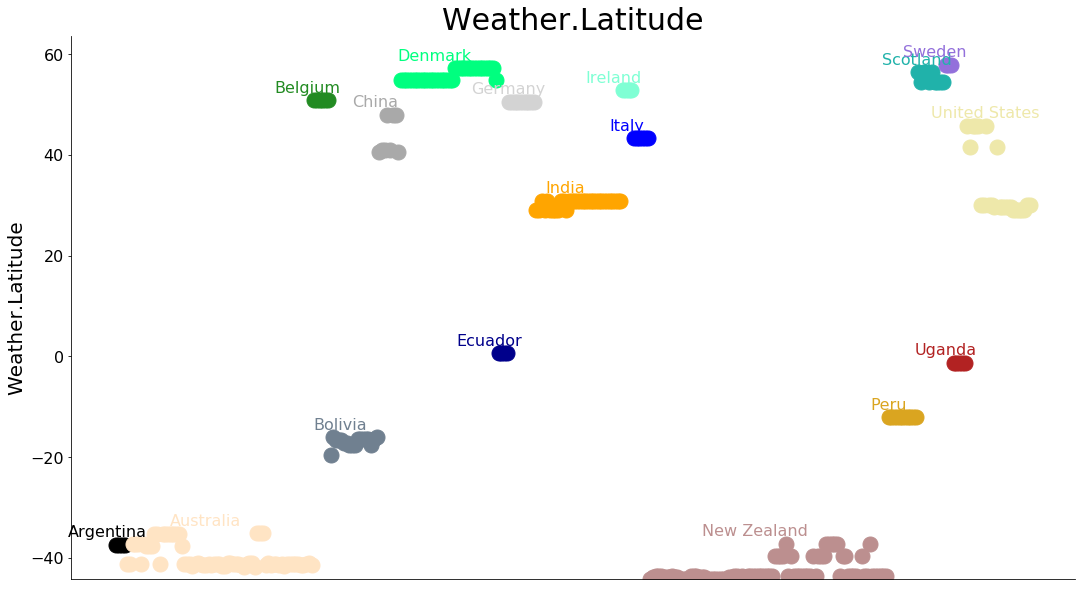

In [86]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
SortedPlot('Weather.Latitude','Country',Countries)

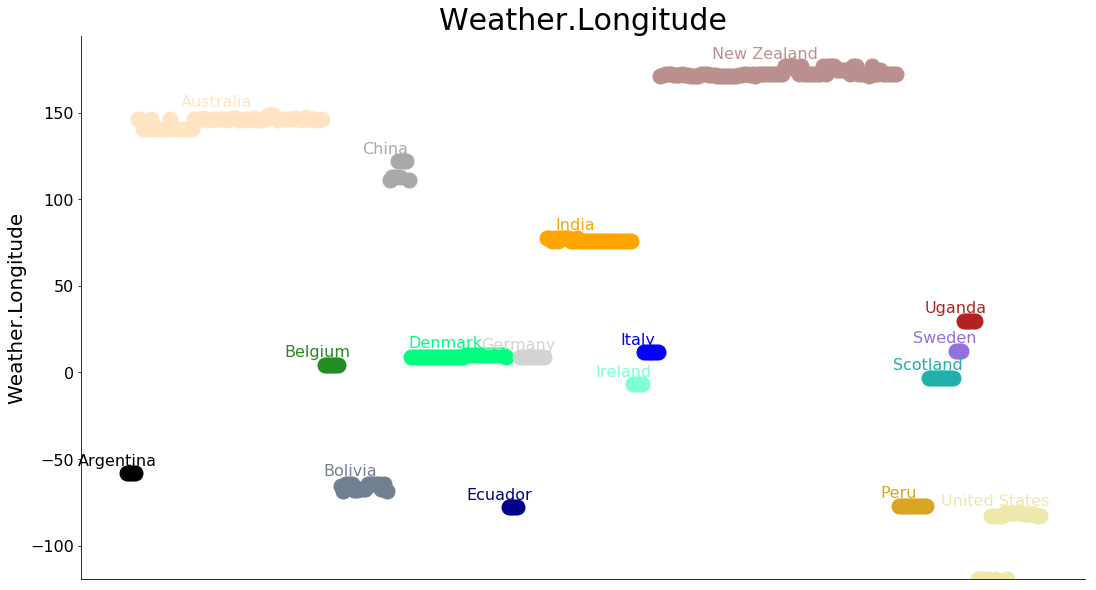

In [87]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
SortedPlot('Weather.Longitude','Country',Countries)

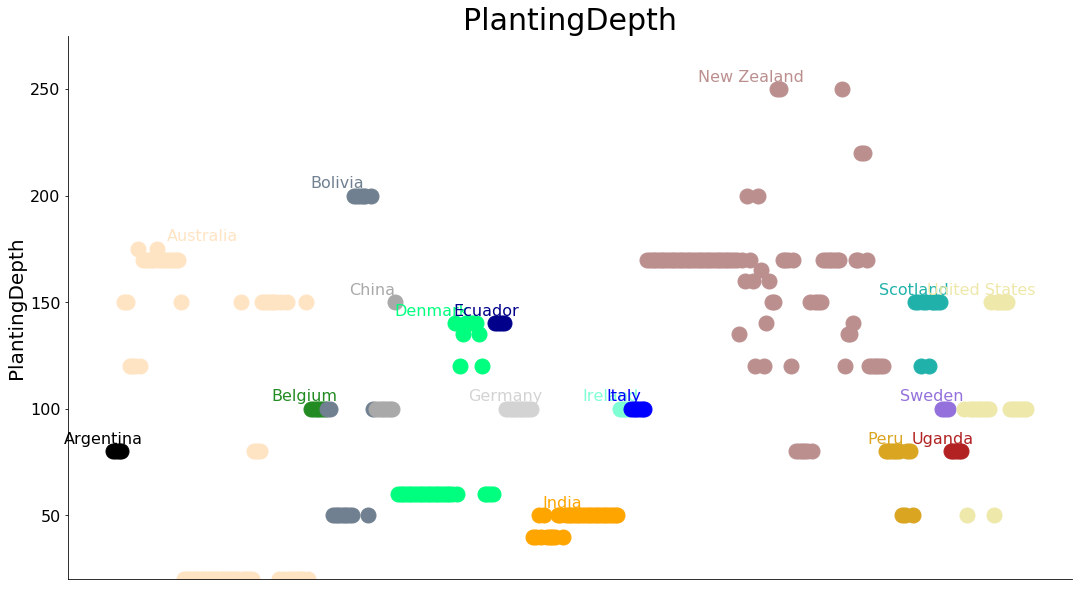

In [88]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
SortedPlot('PlantingDepth','Country',Countries)

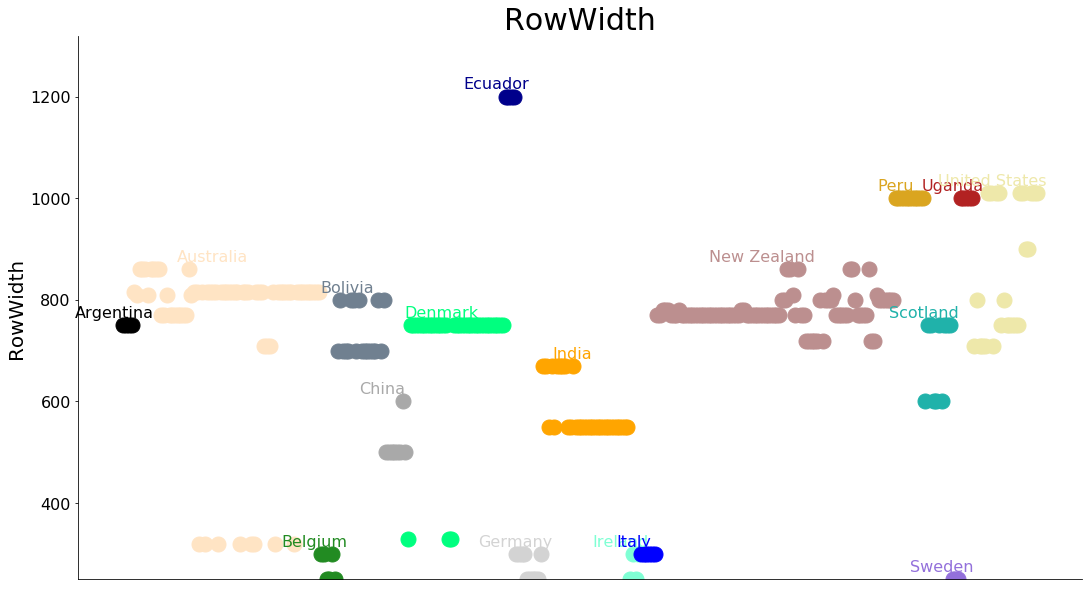

In [89]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
SortedPlot('RowWidth','Country',Countries)

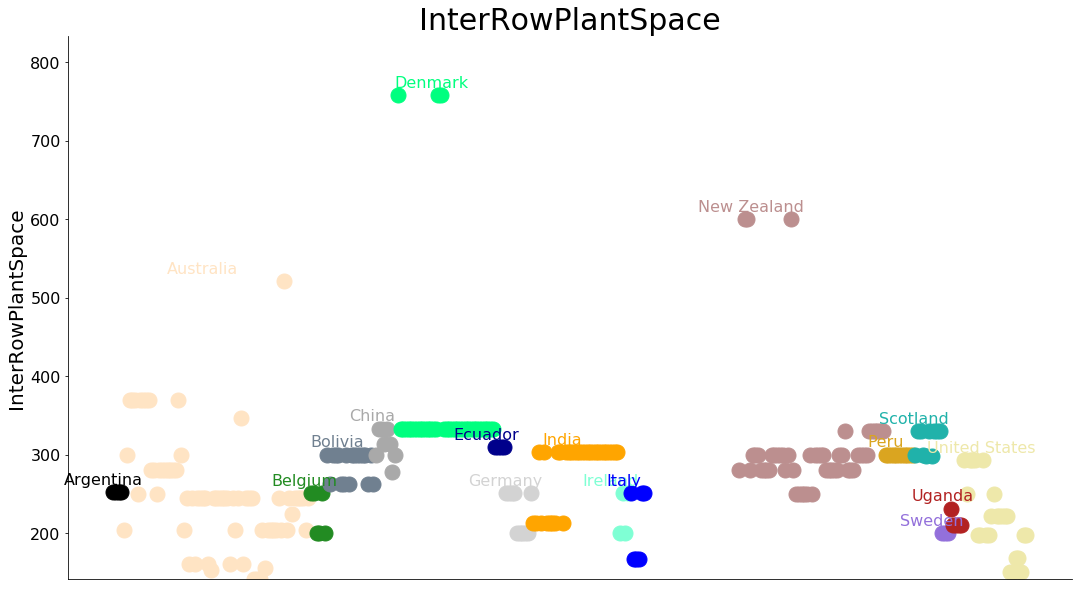

In [90]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
SortedPlot('InterRowPlantSpace','Country',Countries)

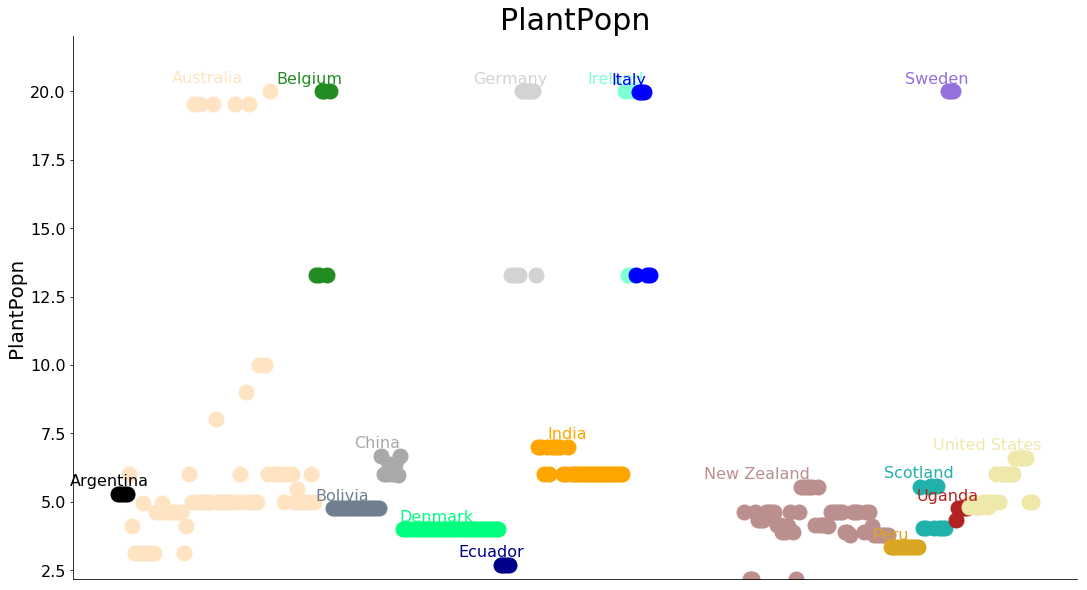

In [101]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
SortedPlot('PlantPopn','Country',Countries)

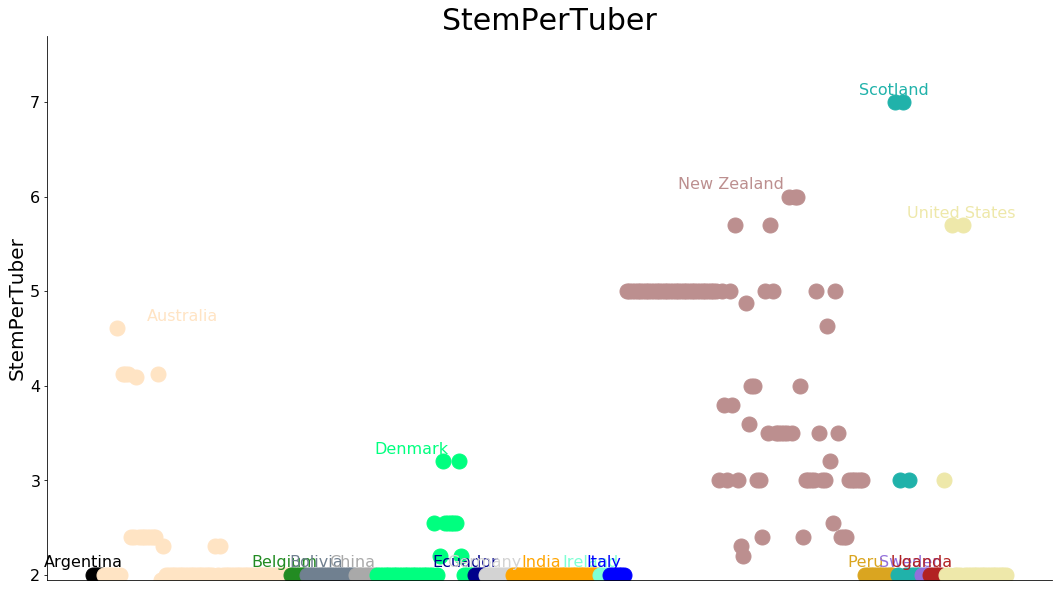

In [104]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
SortedPlot('StemPerTuber','Country',Countries)

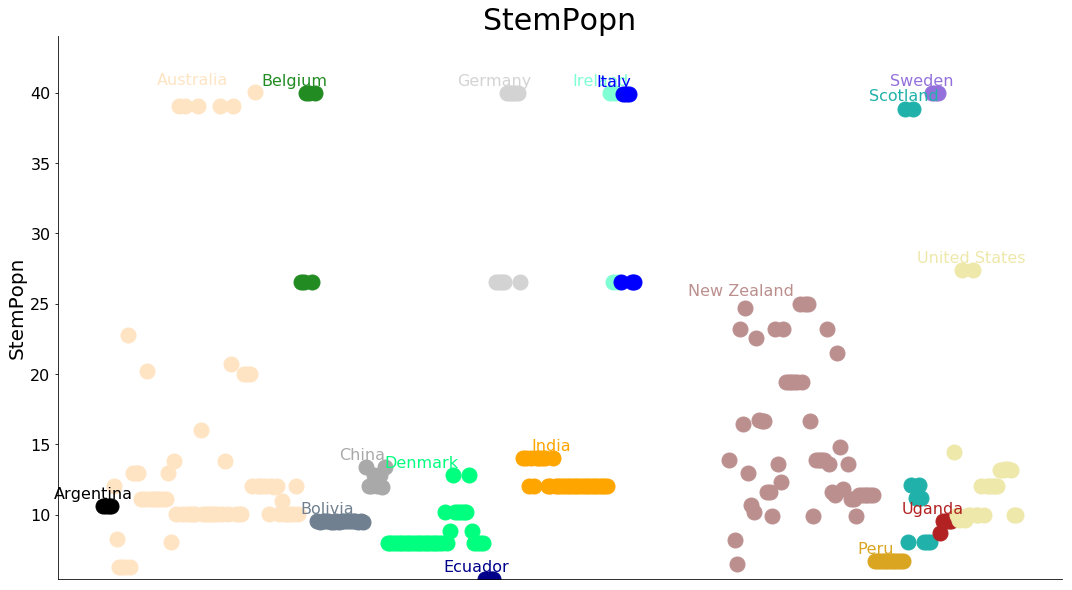

In [93]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
SortedPlot('StemPopn','Country',Countries)

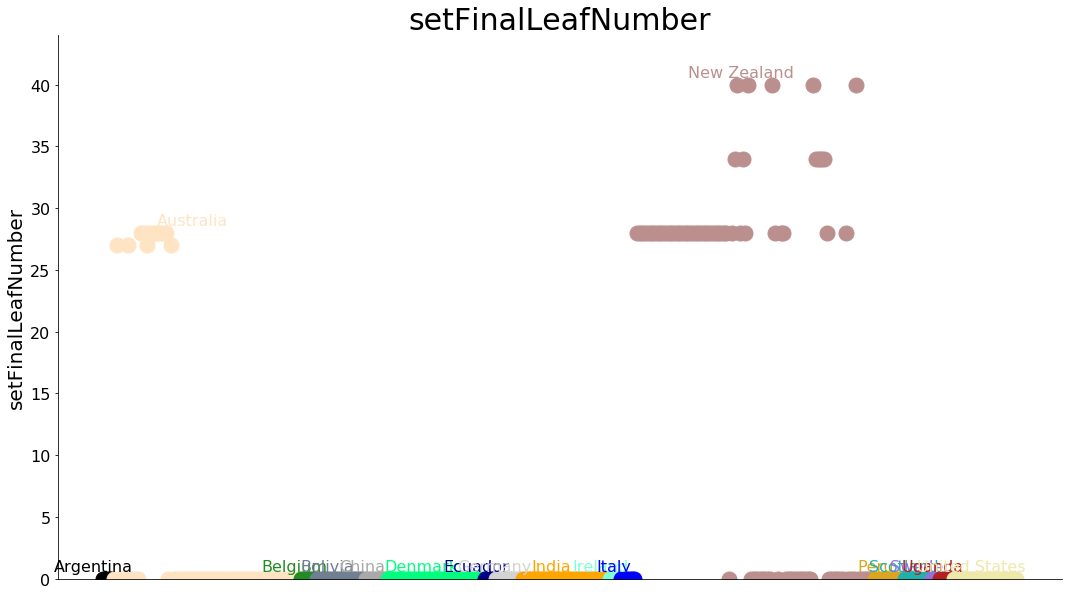

In [94]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
SortedPlot('setFinalLeafNumber','Country',Countries)

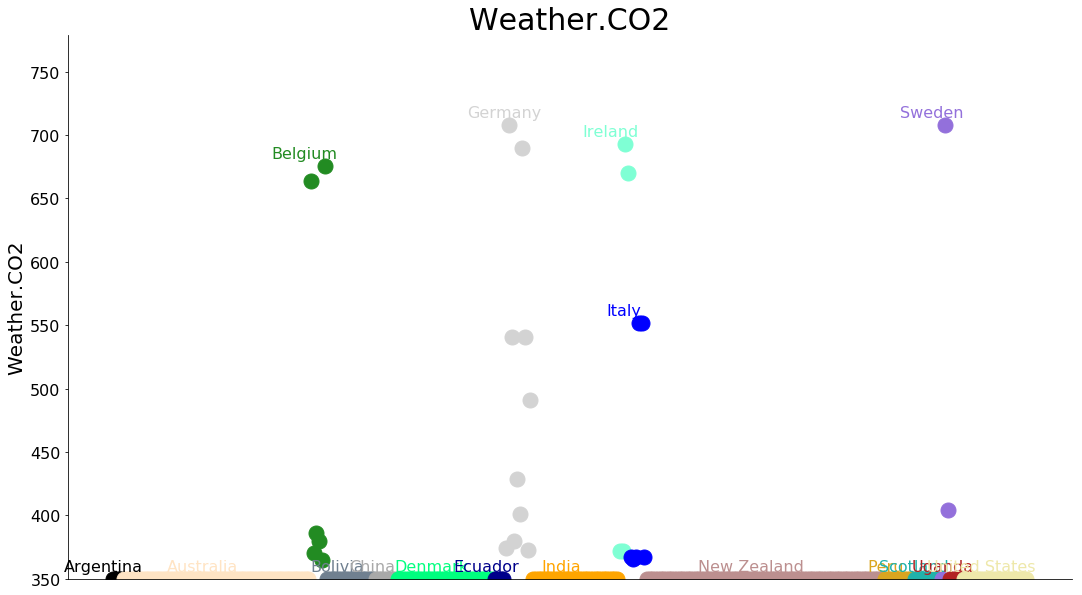

In [95]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
SortedPlot('Weather.CO2','Country',Countries)

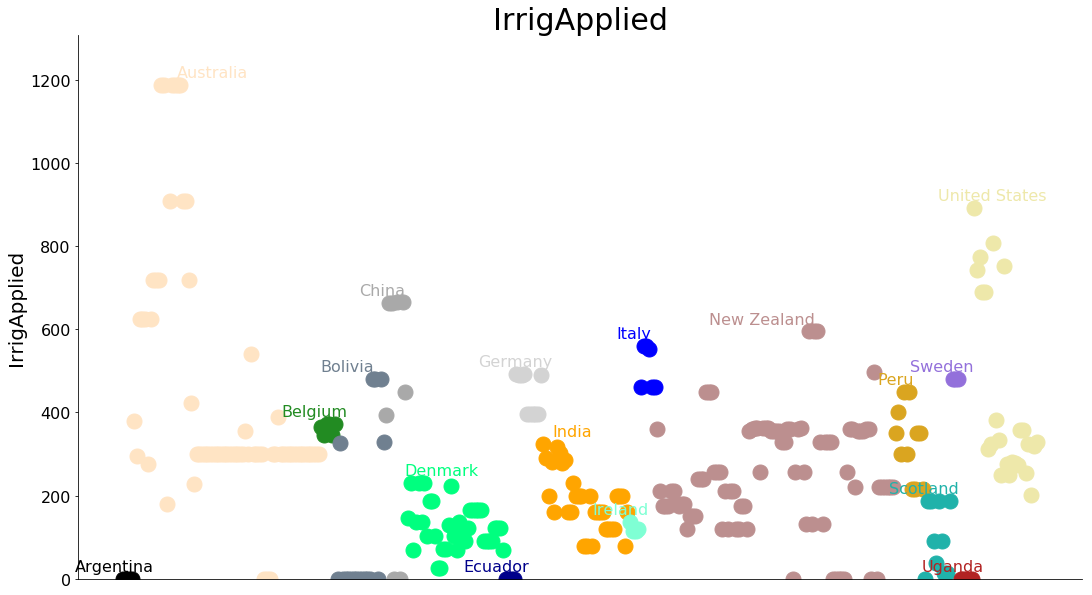

In [96]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
SortedPlot('IrrigApplied','Country',Countries)

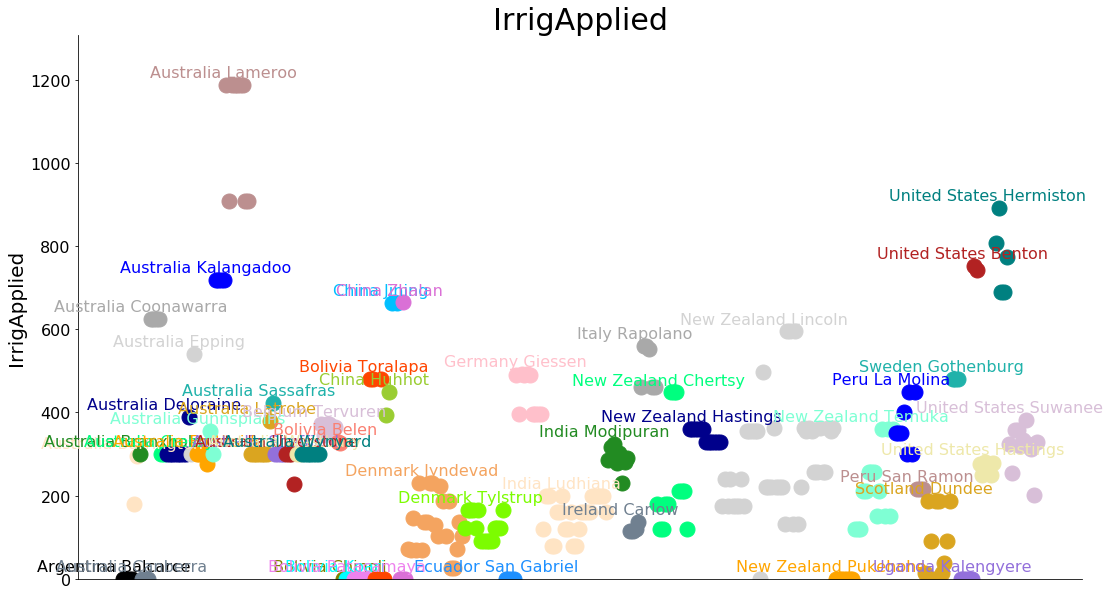

In [97]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
SortedPlot('IrrigApplied','Country Loc',CountryLocs)

In [37]:
HarvestReport.loc[HarvestReport.NFertApplied>700,'SimulationName']

SimulationID
65      Penola_0607Nitrogen750
233    OSBO8801NASA_PIXField_5
Name: SimulationName, dtype: object

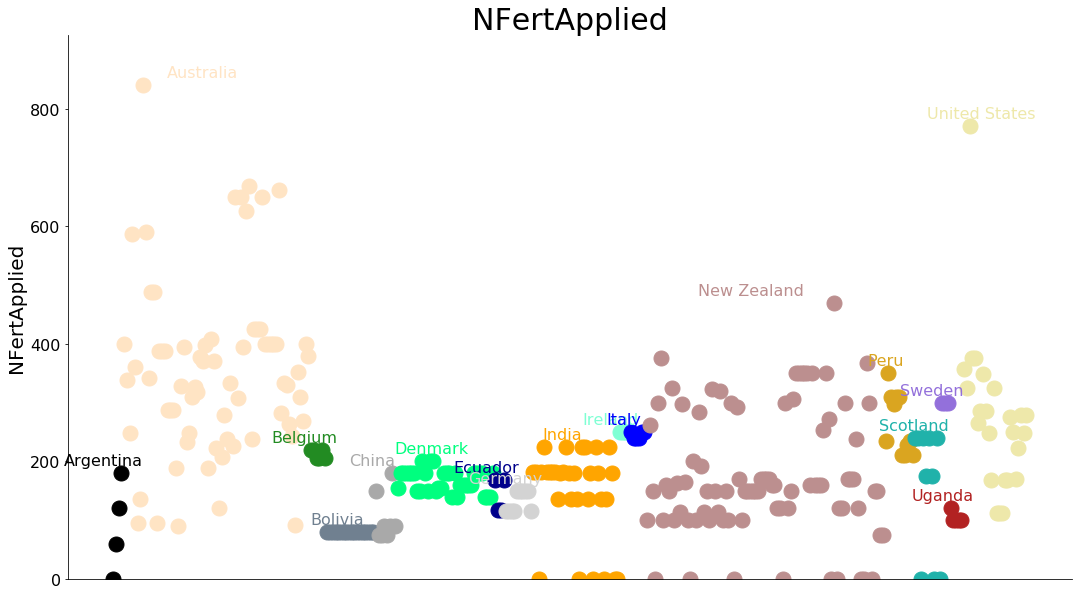

In [98]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
SortedPlot('NFertApplied','Country',Countries)

In [39]:
def plotDepthVars(VarName,depthNorm):
    Thicks = InitialReport.loc[:,[X for X in InitialReport.columns if 'Thickness' in X]]
    Depths = Thicks.cumsum(axis=1)
    Vars = InitialReport.loc[:,[X for X in InitialReport.columns if VarName in X]]
    LayerDB = pd.DataFrame()
    for x in Depths.index:
        SimLayerDB = pd.DataFrame(index = pd.MultiIndex.from_product([[x],['LayerBounds','Varval']]))
        LayerBounds = [0.0]
        depthNormFact = 1 
        if depthNorm == True:
            depthNormFact = Thicks.loc[x,:][0]
        Varvals = [Vars.loc[x,:][0]/depthNormFact]
        for l in range(9):
            try:
                if depthNorm == True:
                    depthNormFact = Thicks.loc[x,:][l]
                LayerBounds.append(float(Depths.loc[x,:][l])*-1)
                Varvals.append(Vars.loc[x,:][l]/depthNormFact)
            except:
                do = 'Nothing'
        for p in range(len(LayerBounds)):
            SimLayerDB.loc[(x,'LayerBounds'),p] = LayerBounds[p]
            SimLayerDB.loc[(x,'Varval'),p] = Varvals[p]
        LayerDB = pd.concat([LayerDB,SimLayerDB])
        LayerDB.index = LayerDB.index.swaplevel()
        LayerBounds = LayerDB.stack().loc['LayerBounds']
        VarVals = LayerDB.stack().loc['Varval']
        LayerDB = pd.concat([LayerDB,SimLayerDB])
    MaxDep = LayerDB.loc[(slice(None),'LayerBounds'),:].min(axis=1).min()
    MinVar = LayerDB.loc[(slice(None),'Varval'),:].min(axis=1).min()
    MaxVar = LayerDB.loc[(slice(None),'Varval'),:].max(axis=1).max()    
    Graph = plt.figure(figsize=(10,20))
    cols = np.ceil(len(Locations)/5)
    pos=1
    for lcn in Locations:
        ax = Graph.add_subplot(cols,5,pos)
        #for x in Depths.index:
        #    plcn = InitialReport.loc[x,'Location']
        plt.plot(VarVals,LayerBounds,'o',color = 'lightgrey')
        plt.text(0.03,1.0,lcn,transform=ax.transAxes,fontsize=12)
        LocalVars = HarvestReport.loc[HarvestReport.loc[:,'Loc']==lcn,:].index
        for l in LocalVars:
            plt.plot(LayerDB.loc[(l,'Varval'),:],LayerDB.loc[(l,'LayerBounds'),:],'-o',color = 'red')
        plt.ylim(MaxDep*1.05,0)
        plt.xlim(MinVar * 0.8,MaxVar * 1.05)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if pos in range(1,200,5):
            plt.tick_params(axis='y', which='both', left=True,right=False, labelleft=True,labelsize=10)
            plt.ylabel('Depth (cm)',fontsize=12)
        else:
            plt.tick_params(axis='y', which='both', left=False,right=False, labelleft=False,labelsize=10)
        if pos in list(range(len(Locations)-4,len(Locations)+1)):
            plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=10)
            plt.xlabel(VarName,fontsize=12)
        else:
            plt.tick_params(axis='x', which='both', bottom=False,top=False, labelbottom=False,labelsize=10)
        pos += 1
    plt.tight_layout

## The flowing series of graphs show CropSoil configuration settings for each simulation so they can be sense checked against the rest of the validation set

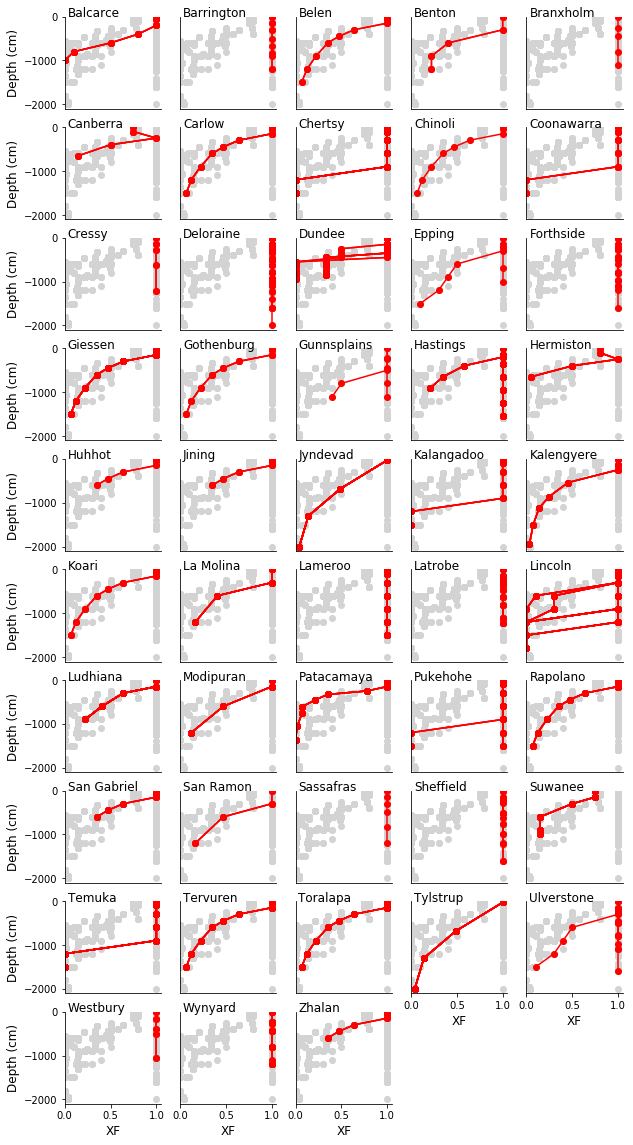

In [40]:
plotDepthVars('XF',False)

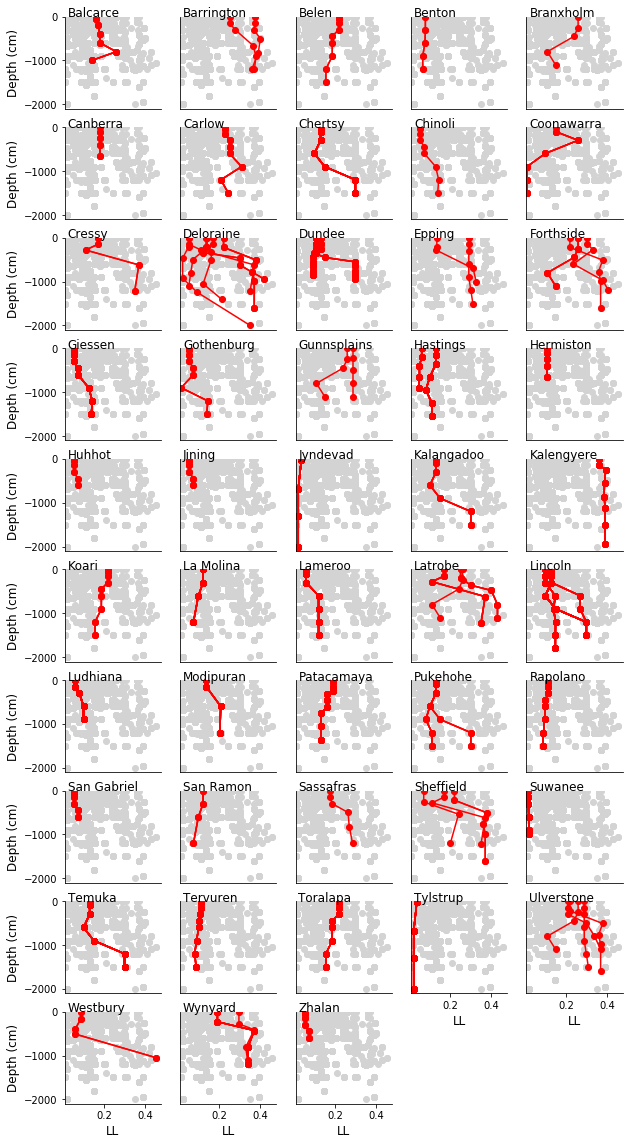

In [41]:
plotDepthVars('LL',False)

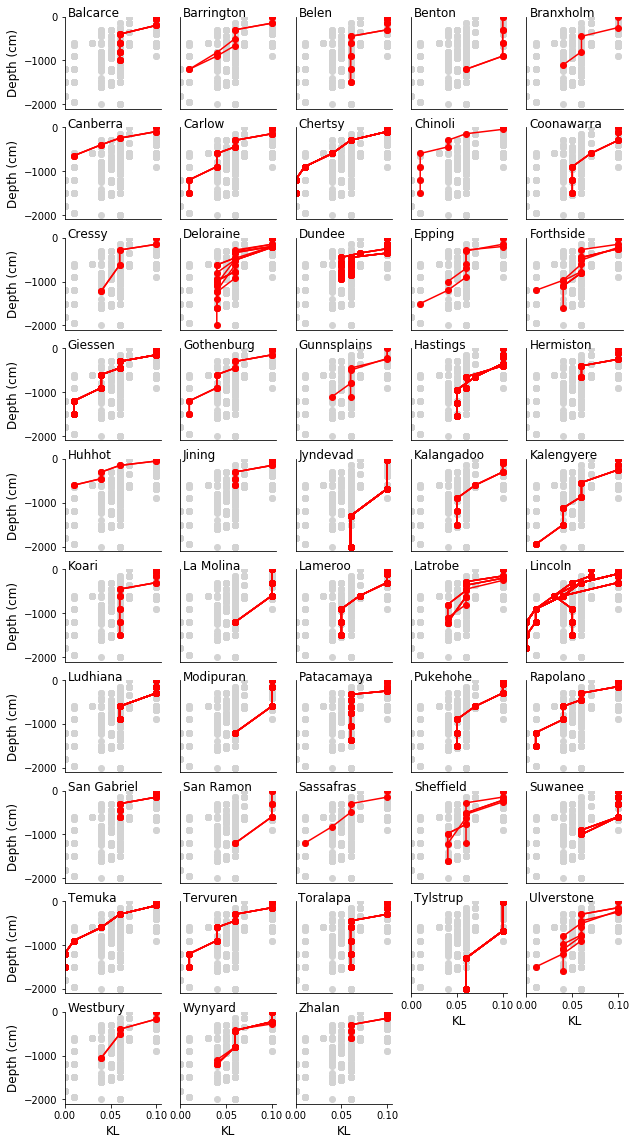

In [42]:
plotDepthVars('KL',False)

In [201]:
def MakeLabel(RegStats):
    #text = RegStats.Name + '  n = ' + str(RegStats.n)
    text = '\ny = ' + '%.2f'%RegStats.Intercept + '(se ' + '%.2f'%RegStats.SEintercept + ') + ' + '%.2f'%RegStats.Slope + '(se ' + '%.2f'%RegStats.SEslope + ') x' 
    text += '\n$r^2$ =' + '%.2f'%RegStats.R2 + ' RMSE = ' + '%.2f'%RegStats.RMSE +' NSE = ' + '%.2f'%RegStats.NSE
    text += '\nME = ' + '%.2f'%RegStats.ME + ' MAE = ' + '%.2f'%RegStats.MAE
    text += '\nn = ' + str(RegStats.n)
    return text

def AddObsPredGraph(Variables,Units,Names,DataTable,rows,cols):
    Pos = 1
    for Var in Variables:
        NaNFilter = np.isnan(DataTable.loc[:,'Predicted.'+Var]) | np.isnan(DataTable.loc[:,'Observed.'+Var])
        IaNFilter = ~NaNFilter
        Obs = DataTable.loc[:,'Observed.'+Var].loc[IaNFilter].values
        Pred = DataTable.loc[:,'Predicted.'+Var].loc[IaNFilter].values
        ax = Graph.add_subplot(rows,cols,Pos)
        ColPos = 0
        MarPos = 0
        for cnt in Countries:
            SimIDs = HarvestReport.loc[HarvestReport.Country == cnt].index.values
            ExpObs = DataTable.loc[SimIDs,'Observed.'+Var]
            ExpPred = DataTable.loc[SimIDs,'Predicted.'+Var]
            plt.plot(ExpObs,ExpPred,Markers[MarPos],color = Colors[ColPos],label=cnt)
            ColPos +=1
            if ColPos == 30:
                ColPos = 1
                MarPos +=1
        uplim = max(Obs.max(),Pred.max())*1.1
        lowlim = min(Obs.min(),Pred.min())*0.95
        plt.text(0.02,0.94,Var,transform=ax.transAxes)
        plt.ylim(0,uplim)
        plt.xlim(0,uplim)
        plt.plot([lowlim,uplim*.95],[lowlim,uplim*.95],'-')
        RegStats = MUte.MathUtilities.CalcRegressionStats(Var,Pred,Obs)
        LabelText = MakeLabel(RegStats)
        #plt.text(uplim*0.05,uplim*.78,LabelText)
        #Fit linear regression to current series and store slope and intercept in dataframe
        ModFit = sm.regression.linear_model.OLS(Pred,  # Y variable
                                            sm.add_constant(Obs), # X variable
                                            missing='drop',                                     # ignor and data where one value is missing
                                            hasconst=False) 
        RegFit = ModFit.fit();  # fit models parameters
        Slope = RegFit.params[1] 
        Intercept = RegFit.params[0]
        Xs = [lowlim,uplim*.95]
        Ys = [Intercept + Xs[0]*Slope,Intercept + Xs[1]*Slope]
        plt.plot(Xs,Ys,'--')
        Pos +=1

## Standard Obs vs Pred graph for Harvest

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


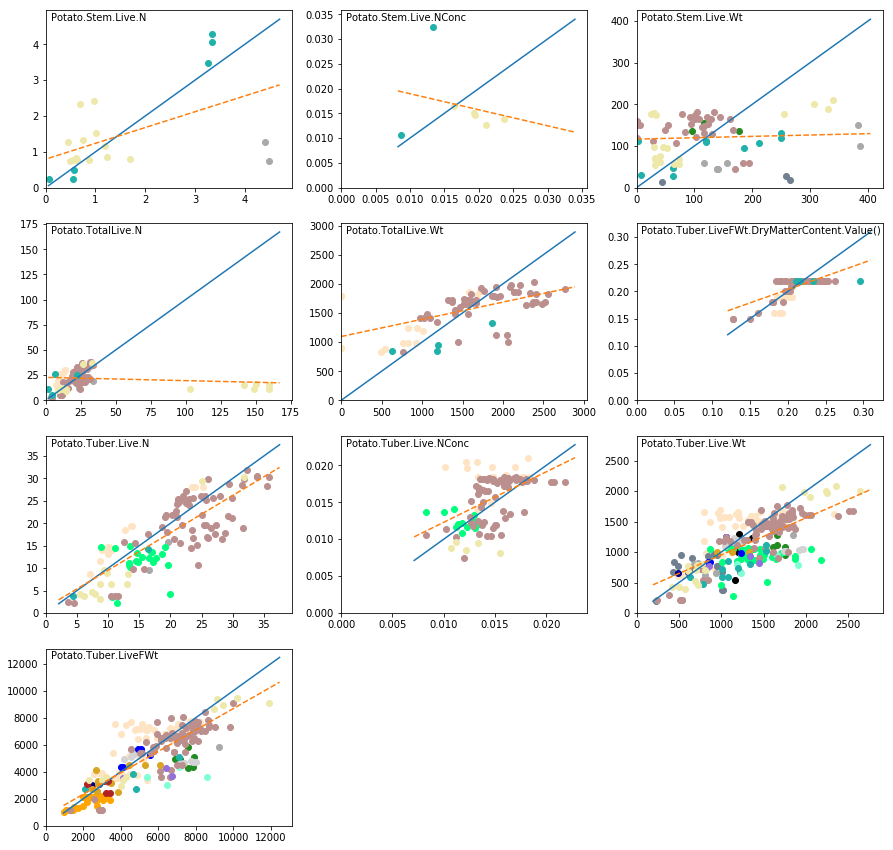

In [202]:
Graph = plt.figure(figsize=(15,15))
AllVars = HarvestPreObs.loc[:,['Observed' in x for x in HarvestPreObs.columns ]].columns.values
for i in range(len(AllVars)):
    AllVars[i] = AllVars[i].replace('Observed.','')
AllVars = AllVars[['CheckpointID' not in x and 'Clock' not in x for x in AllVars]]

Variables = AllVars#['Tuber.Live.Wt','Tuber.LiveFWt','Tuber.Live.N',
             #'Tuber.LiveFWt.DryMatterContent.Value()','TotalLive.Wt','TotalLive.N']
Units = ['$g/m^3$','$/m^3$','$g/m^3$',
        '$g/m^3$','$g/m^3$','$g/m^3$',
        'days','days']
Names = ['Tuber Dry Weight','Tuber Fresh Weight', 'Tuber N','DMC','Total Wt', 'Total N']
AddObsPredGraph(Variables,Units,Names,HarvestPreObs,4,3)

## Standard Obs vs Pre graph for time series data

In [189]:
AllVars

array(['AboveGround.Live.N', 'AboveGround.Dead.N', 'AboveGround.Live.Wt',
       'AboveGround.Dead.Wt', 'TotalLive.Wt', 'TotalLive.N',
       'Leaf.AppearedCohortNo', 'Leaf.CoverGreen', 'Leaf.CoverTotal',
       'Leaf.LAI', 'Leaf.Live.N', 'Leaf.Live.Wt', 'Leaf.Live.NConc',
       'Leaf.SpecificArea', 'Stem.Live.N', 'Stem.Live.NConc',
       'Stem.Live.Wt', 'Tuber.LiveFWt.DryMatterContent.Value()',
       'Tuber.Live.N', 'Tuber.Live.NConc', 'Tuber.Live.Wt',
       'Tuber.LiveFWt', 'Observed.Soil.SoilWater.SW(1)',
       'Observed.Soil.SoilWater.SW(2)', 'Observed.Soil.SoilWater.SW(3)',
       'Observed.Soil.SoilWater.SW(4)', 'Observed.Soil.SoilWater.SW(5)',
       'Observed.Soil.SoilWater.SW(6)', 'Observed.TotalSWC',
       'Observed.TotalSoilN', 'Observed.TotalNO3', 'Observed.TotalNH4',
       'Observed.Soil.SoilWater.SW(7)'], dtype=object)

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:1027: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
C:\Anaconda\lib\MathsUtilities.py:766: RuntimeWarning: invalid value encountered in sqrt
  stats.SEslope = np.sqrt(S2) / np.sqrt(CSSX) # Standard errors estimated from S2 & CSSX
C:\Anaconda\lib\MathsUtilities.py:767: RuntimeWarning: invalid value encountered in sqrt
  stats.SEintercept = np.sqrt(S2) * np.sqrt(SumX2 / (Num_points * CSSX))


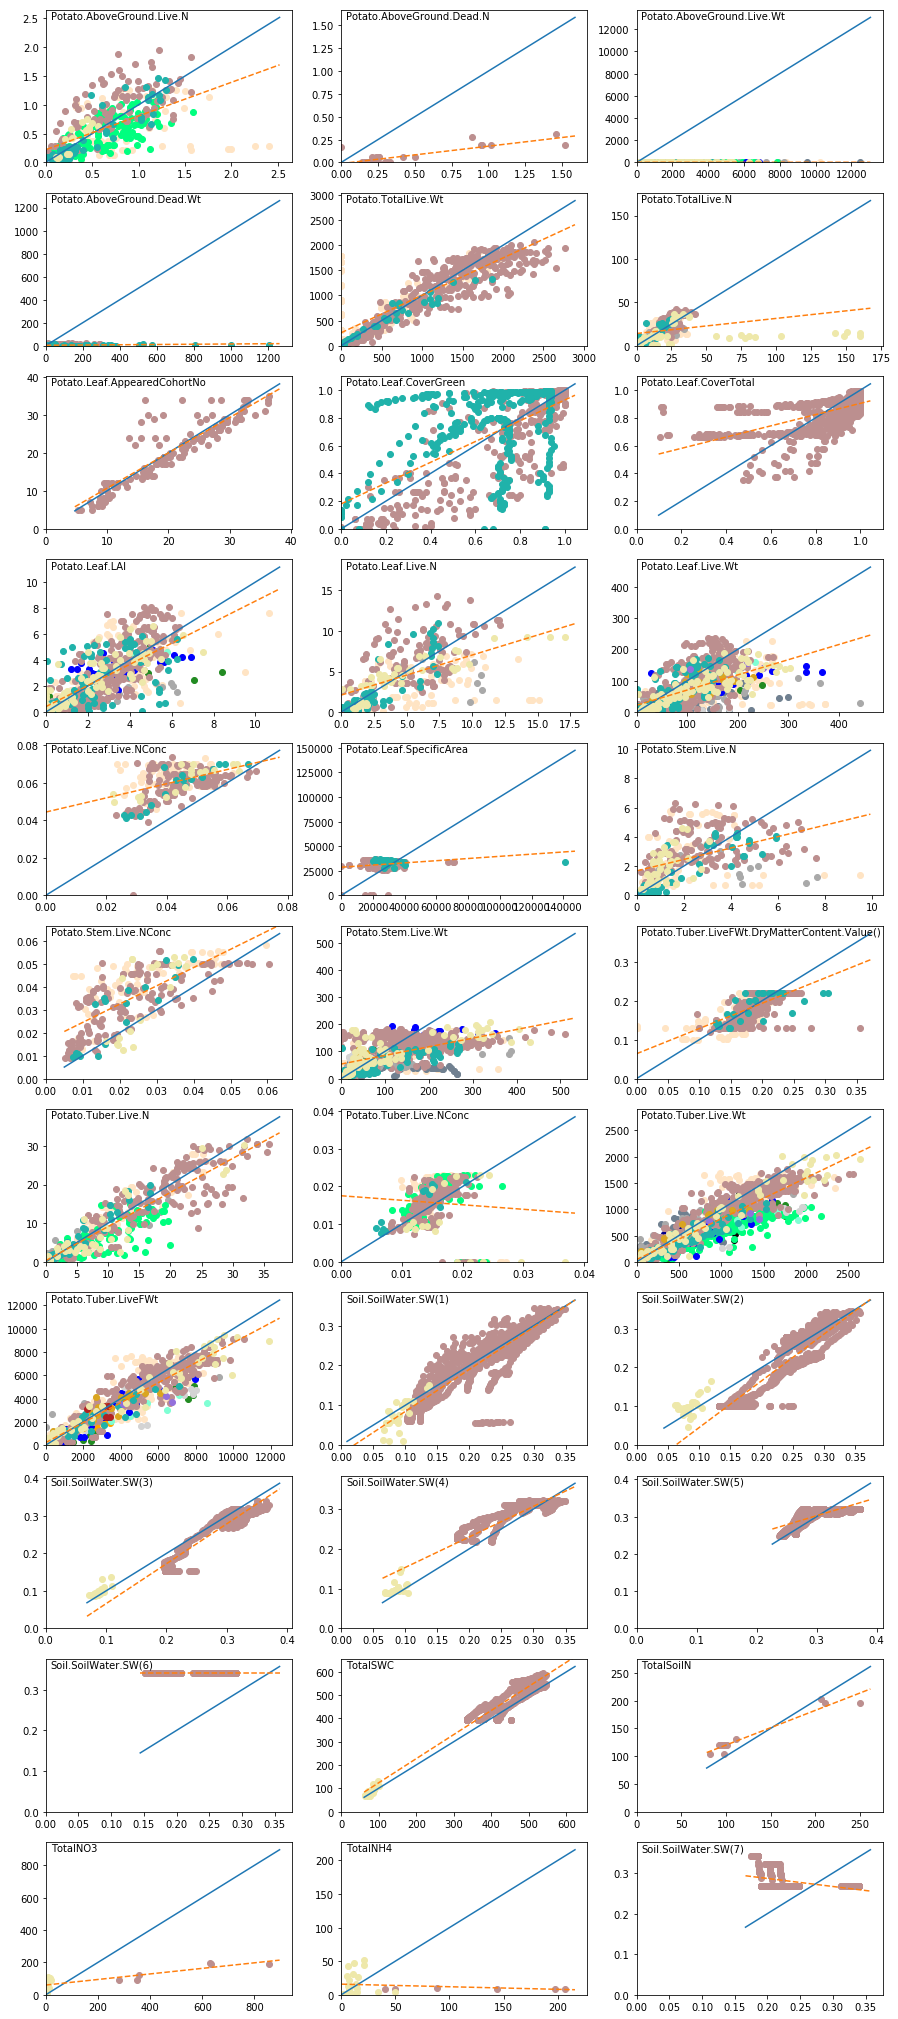

In [204]:
Graph = plt.figure(figsize=(15,50))
AllVars = DailyPreObs.loc[:,['Observed' in x for x in DailyPreObs.columns ]].columns.values
for i in range(len(AllVars)):
    AllVars[i] = AllVars[i].replace('Observed.','')
AllVars = AllVars[['CheckpointID' not in x and 'FinalTag' not in x for x in AllVars]]
Variables = AllVars#['Tuber.Live.Wt','Tuber.LiveFWt','Tuber.Live.N',
#              'Tuber.LiveFWt.DryMatterContent.Value()','TotalLive.Wt','TotalLive.N']
Units = ['$g/m^3$','$/m^3$','$g/m^3$',
        '$g/m^3$','$g/m^3$','$g/m^3$',
        'days','days']
Names = ['Tuber Dry Weight','Tuber Fresh Weight', 'Tuber N','DMC','Total Wt', 'Total N']
AddObsPredGraph(Variables,Units,Names,DailyPreObs,15,3)

In [47]:
HarvestResiduals = HarvestPreObs.loc[:,[X for X in HarvestPreObs.columns if 'Pred-Obs' in X]].copy()

In [48]:
def GroupResidulesGraph(ResidulesTable,Grouping,GroupLabel):
    panpos = 1
    Variables = ['Tuber.LiveFWt.DryMatterContent.Value()','Tuber.Live.N', 
 'Tuber.Live.NConc','Tuber.Live.Wt', 'Tuber.LiveFWt']
    for Var in Variables:
        ax = Graph.add_subplot(5,1,panpos)
        startx = 0
        tickPoss = []
        tickLabs = []
        colpos = 1
        upper = ResidulesTable.loc[:,'Pred-Obs.Potato.' + Var].max() * 1.1
        lower = ResidulesTable.loc[:,'Pred-Obs.Potato.' + Var].min() * 1.1
        MeanResidual = ResidulesTable.loc[:,'Pred-Obs.Potato.' + Var].mean()
        TextPos = 'Lower'
        for group in Grouping:
            SimIDs = HarvestReport.loc[HarvestReport.loc[:,GroupLabel]==group,:].index.values
            xvals = range(startx,startx+len(SimIDs))
            plt.plot(xvals,ResidulesTable.reindex(SimIDs,axis=0).loc[:,'Pred-Obs.Potato.' + Var],
                     '-o',color=Colors[colpos])
            #tickPoss.append(startx+len(SimIDs)/2)
            tickLabs.append(group)
            if TextPos=='Lower':
                plt.text(startx+len(SimIDs)/2,lower,group,fontsize=16,
                         color=Colors[colpos],rotation=-45,verticalalignment='bottom',horizontalalignment='center')
                TextPos = 'Upper'
            else:
                plt.text(startx+len(SimIDs)/2,upper,group,fontsize=16,
                         color=Colors[colpos],rotation=-45,verticalalignment='top',horizontalalignment='center')
                TextPos = 'Lower'
            startx += len(SimIDs)
            if colpos == 30:
                colpos = 0
            colpos+=1
        ax.xaxis.set_major_locator(plt.FixedLocator(tickPoss))
        ax.set_xticklabels(tickLabs)
        plt.tick_params(rotation=90)
        plt.plot([0,startx],[MeanResidual,MeanResidual],'-',lw=3,color='k')
        plt.plot([0,startx],[0,0],'--',lw=3,color='k')
        plt.ylim(lower,upper)
        plt.title(Var,fontsize=25)
        plt.ylabel('Pred-Obs')
        panpos+=1

## Graph residuals for key variables grouped by cultivar

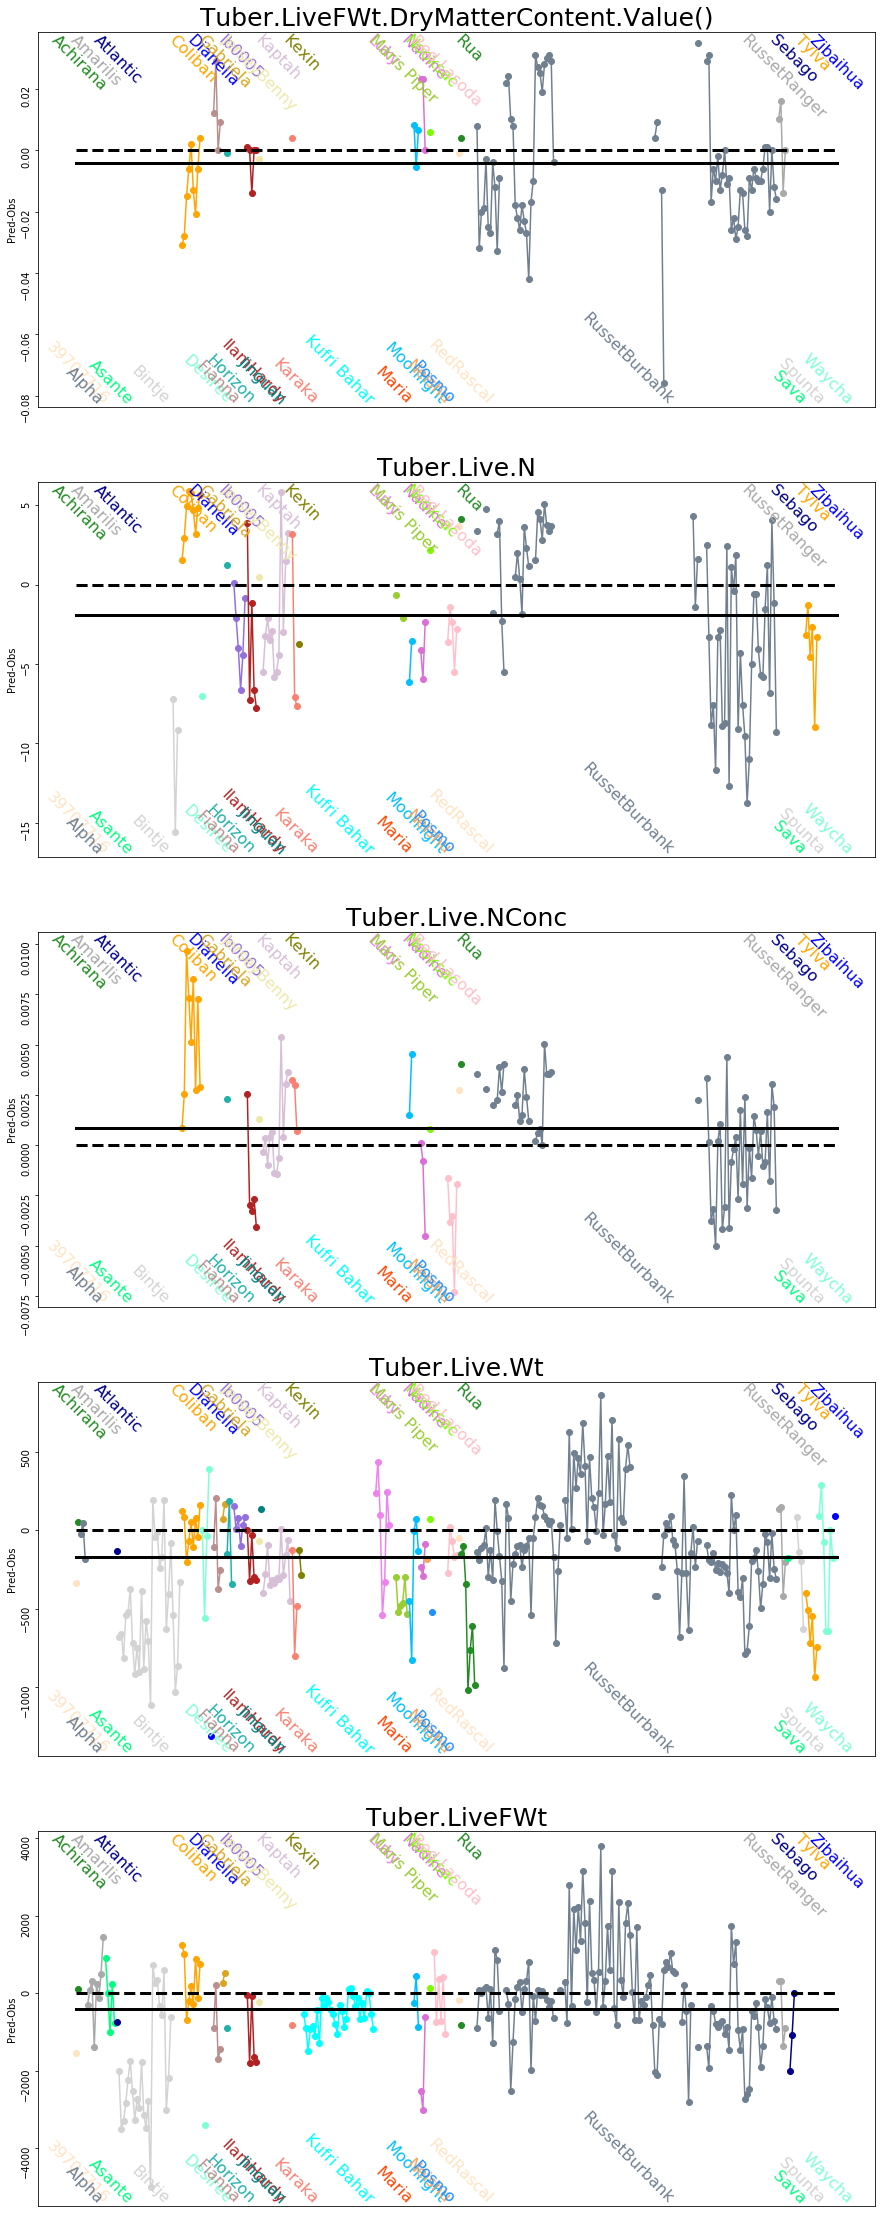

In [49]:
Graph = plt.figure(figsize=(15,40))
GroupResidulesGraph(HarvestResiduals,Cultivars,'Cultivar')

## Graph residuals for key variables grouped by location

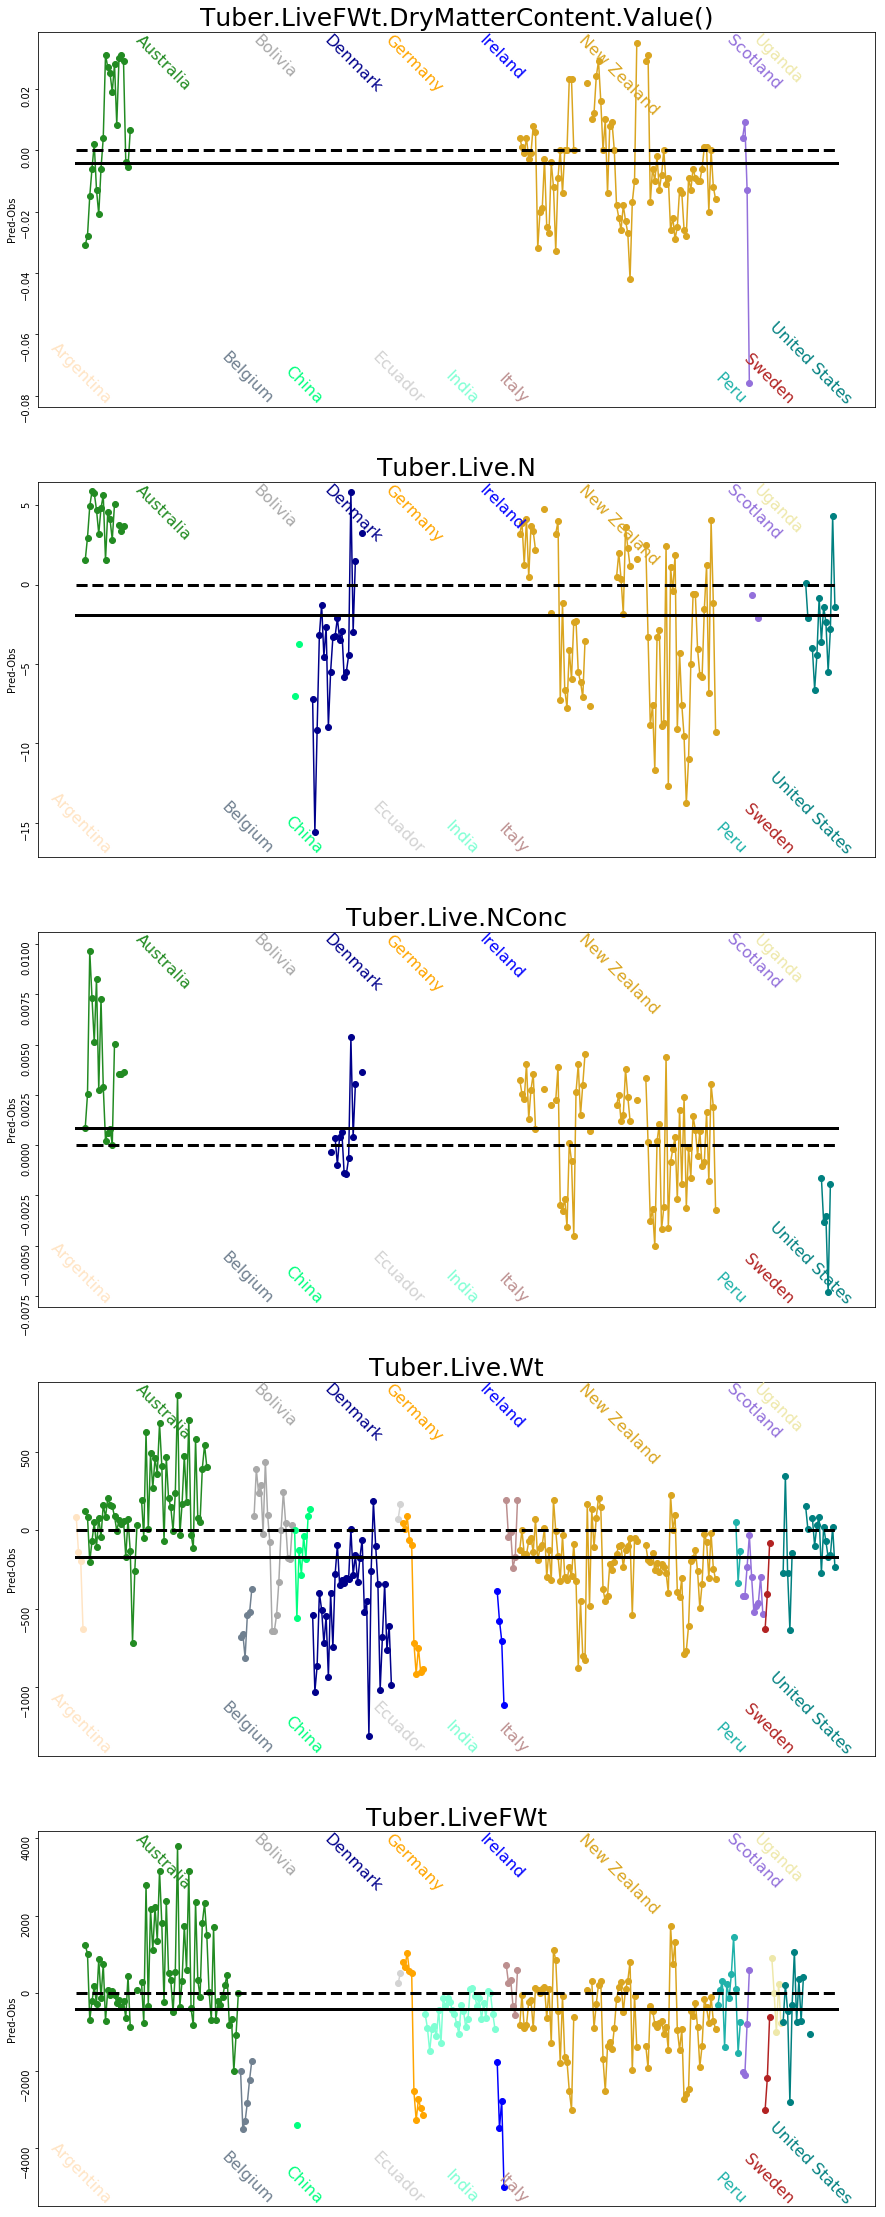

In [50]:
Graph = plt.figure(figsize=(15,40))
GroupResidulesGraph(HarvestResiduals,Countries,'Country')

## Make graphs of residuals vs simulation configuration variables

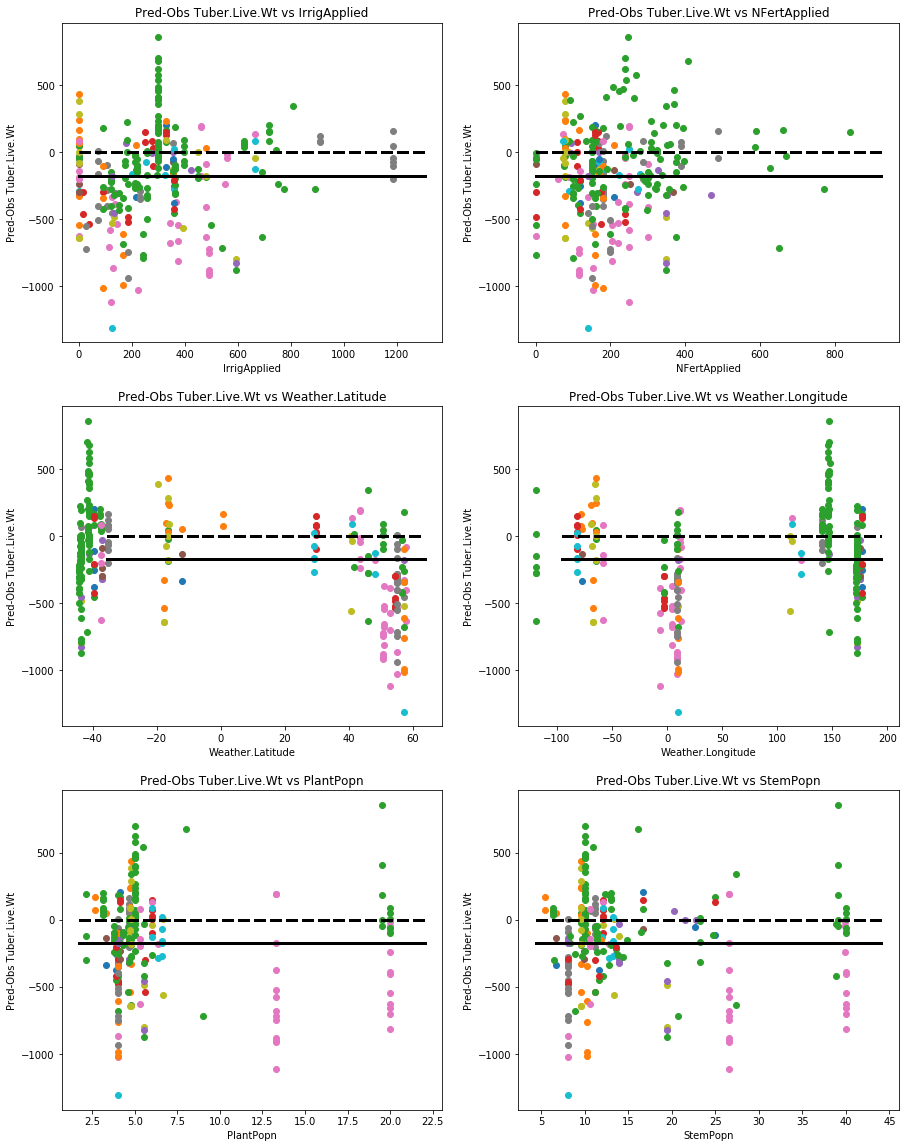

In [51]:
def ResidulesVsVariable(ResidulesTable,Variable,Grouping,GroupLabel):
    pos = 1
    for vsVariable in ['IrrigApplied','NFertApplied','Weather.Latitude',
                       'Weather.Longitude','PlantPopn','StemPopn']:
        Graph.add_subplot(3,2,pos)
        for group in Grouping:
            SimIDs = HarvestReport.loc[HarvestReport.loc[:,GroupLabel]==group,:].index.values
            yvals = ResidulesTable.reindex(SimIDs,axis=0).loc[:,'Pred-Obs.Potato.'+Variable]
            xvals = HarvestReport.reindex(SimIDs,axis=0).loc[:,vsVariable]
            plt.plot(xvals,yvals,'o')
            upper = HarvestReport.loc[:,vsVariable].max() * 1.1
            lower = HarvestReport.loc[:,vsVariable].min() * 0.8
            MeanResidual = ResidulesTable.loc[:,'Pred-Obs.Potato.' + Variable].mean()
            plt.plot([lower,upper],[MeanResidual,MeanResidual],'-',lw=3,color='k')
            plt.plot([lower,upper],[0,0],'--',lw=3,color='k')
            plt.title('Pred-Obs ' + Variable + ' vs ' + vsVariable)
            plt.ylabel('Pred-Obs ' + Variable)
            plt.xlabel(vsVariable)
        pos+=1
Graph = plt.figure(figsize=(15,20))
ResidulesVsVariable(HarvestResiduals,'Tuber.Live.Wt',Cultivars,'Cultivar')

In [52]:
DailyObsPredSims = DailyPreObs.index.drop_duplicates()
SimsWithTimeCoarsData = []
for sim in DailyObsPredSims:
    try:
        obsNo = len(DailyPreObs.loc[sim,'Clock.Today'].values)
        if obsNo>1:
            SimsWithTimeCoarsData.append(sim)
    except:
        do = 'Nothing'
LocationsWithTimeCoarseData = HarvestReport.reindex(SimsWithTimeCoarsData,axis=0).loc[:,'Loc'].dropna().drop_duplicates().values
LocationsWithTimeCoarseData.sort()
CultivarsWithTimeCoarseData = HarvestReport.reindex(SimsWithTimeCoarsData,axis=0).loc[:,'Cultivar'].dropna().drop_duplicates().values
CultivarsWithTimeCoarseData.sort()
CountriesWithTimeCoarseData = HarvestReport.reindex(SimsWithTimeCoarsData,axis=0).loc[:,'Country'].dropna().drop_duplicates().values
CountriesWithTimeCoarseData.sort()


In [56]:
def ResidulesVsTtSow(Variable,Grouping,GroupLabel):
    cols = np.ceil(len(Grouping)/5)
    pos=1
    upper = DailyPreObs.loc[:,'Pred-Obs.Potato.'+Variable].max() * 1.1
    lower = DailyPreObs.loc[:,'Pred-Obs.Potato.'+Variable].min() * 0.8
    MeanResidual = DailyPreObs.loc[:,'Pred-Obs.Potato.'+Variable].mean()

    for group in Grouping:
        ax = Graph.add_subplot(cols,5,pos)
        simsInGroup = HarvestReport.loc[HarvestReport.loc[:,GroupLabel]==group].index
        GroupSimsWithTimeCoarseData = list(set(HarvestReport.loc[HarvestReport.loc[:,GroupLabel]==group].index) & set(SimsWithTimeCoarsData))
        for sim in GroupSimsWithTimeCoarseData:
            residuals = DailyPreObs.loc[sim,'Pred-Obs.Potato.'+Variable]
            DatesWithObs = DailyReport.loc[:,'Clock.Today'].isin(DailyPreObs.loc[sim,'Clock.Today'])
            TtSow = DailyReport.loc[DatesWithObs,:].loc[sim,'Potato.Phenology.AccumulatedEmergedTT'].values
            try:
                plt.plot(TtSow,residuals,'o',color='red')
            except:
                print(sim)
        plt.text(0.03,1.0,group,transform=ax.transAxes,fontsize=12)
        plt.ylim(lower,upper)
        plt.plot([0,2300],[MeanResidual,MeanResidual],'-',lw=3,color='k')
        plt.plot([0,2300],[0,0],'--',lw=3,color='k')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if pos in range(1,200,5):
            plt.tick_params(axis='y', which='both', left=True,right=False, labelleft=True,labelsize=10)
            plt.ylabel('Pred-Obs '+Variable,fontsize=12)
        else:
            plt.tick_params(axis='y', which='both', left=False,right=False, labelleft=False,labelsize=10)
        if pos in list(range(len(Grouping)-4,len(LocationsWithTimeCoarseData)+1)):
            plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=10)
            plt.xlabel('TtAccumSow',fontsize=12)
        else:
            plt.tick_params(axis='x', which='both', bottom=False,top=False, labelbottom=False,labelsize=10)
        pos+=1
    plt.tight_layout

## Make Graphs of tuber live Wt residuals for each location plotted against thermal time since sowing

## Make Graphs of tuber live Wt residuals for each Cultivar plotted against thermal time since sowing

44
45
46
47
48
49
50
120


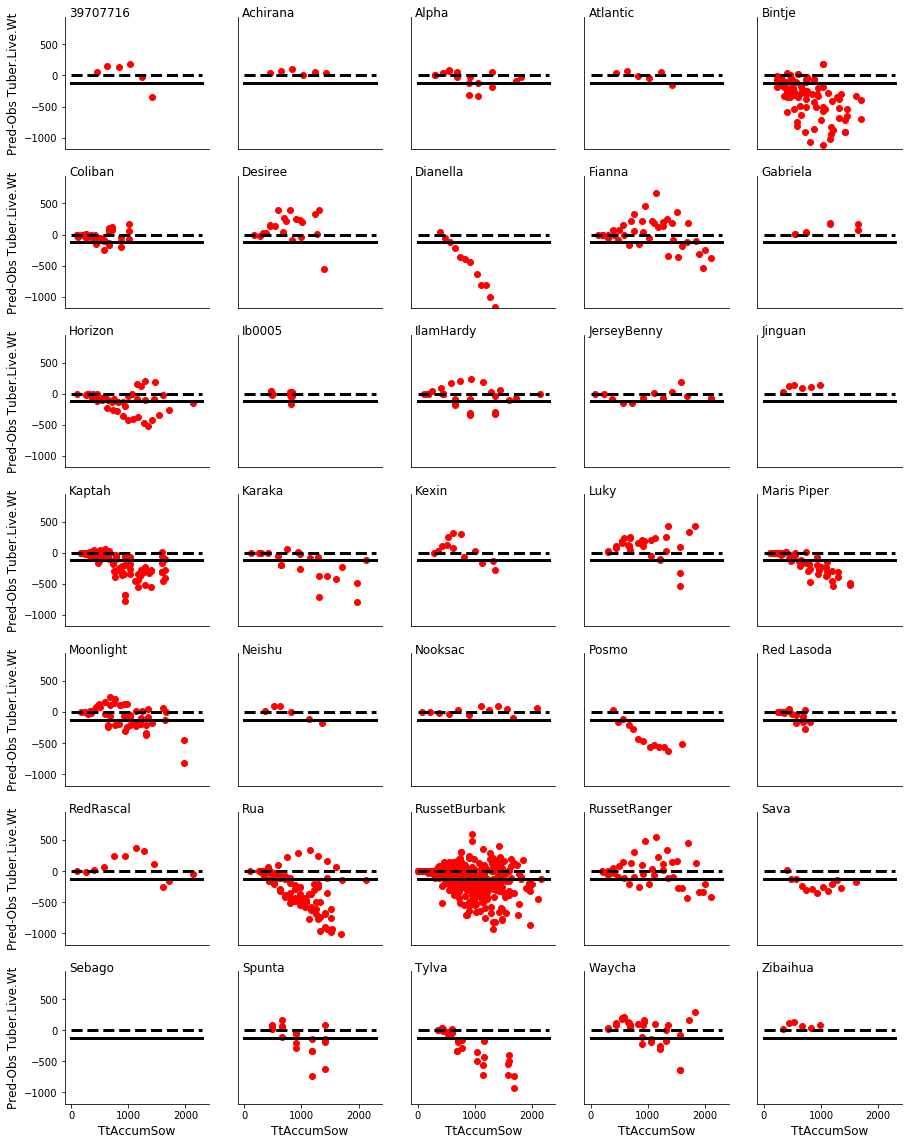

In [57]:
Graph = plt.figure(figsize=(15,20))
ResidulesVsTtSow('Tuber.Live.Wt',CultivarsWithTimeCoarseData,'Cultivar')

## Make Graphs of LAI residuals for each cultivar plotted against thermal time since sowing

44
45
46
47
48
49
50
120


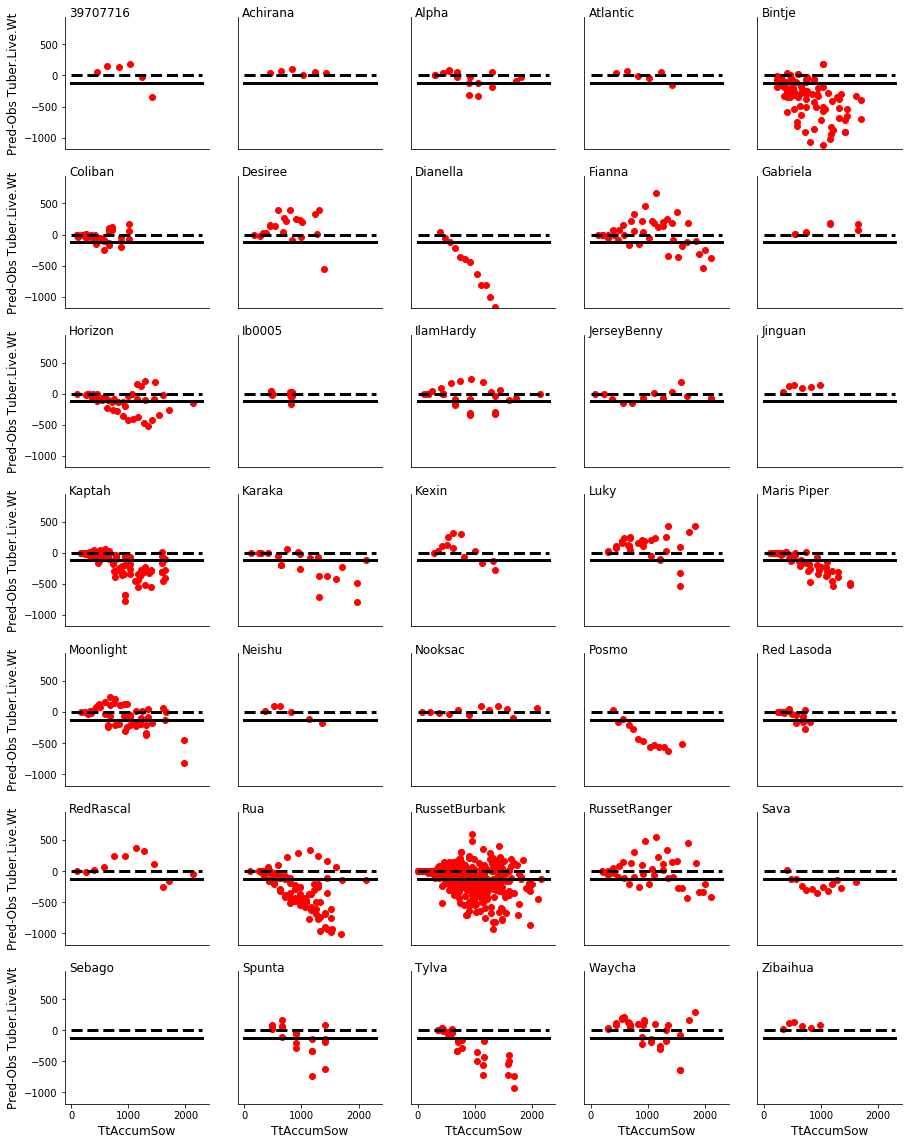

In [58]:
Graph = plt.figure(figsize=(15,20))
ResidulesVsTtSow('Tuber.Live.Wt',CultivarsWithTimeCoarseData,'Cultivar')

44
45
46
47
48
49
50
120


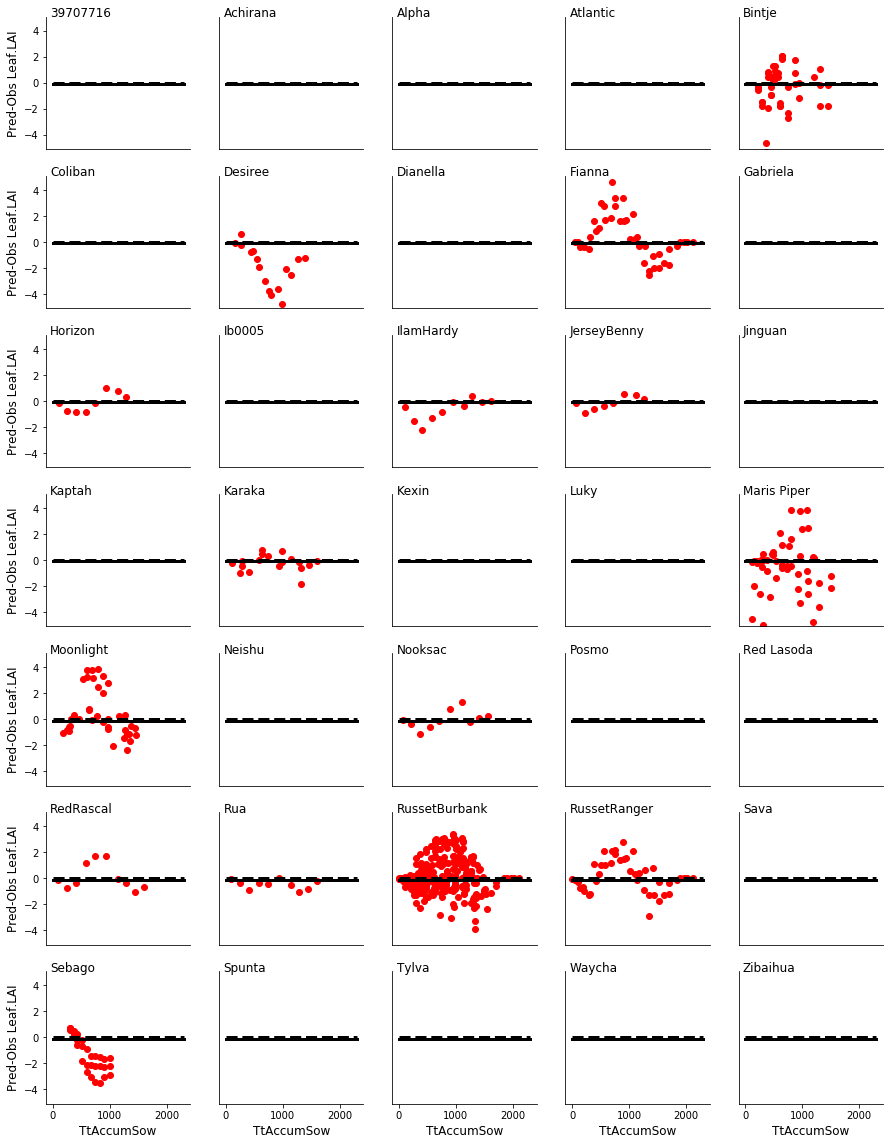

In [59]:
Graph = plt.figure(figsize=(15,20))
ResidulesVsTtSow('Leaf.LAI',CultivarsWithTimeCoarseData,'Cultivar')